In [ ]:
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor
from tqdm import tqdm

In [102]:
def plot_reward(episode_rewards, env_end_idx):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Episode Reward")

    for x in env_end_idx:
        plt.axvline(x=x, color="red", linestyle="--")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    plt.grid()
    plt.show()

## Action space change

Periodically change action space indexing (i.e. [0, 1, 2] -> [2, 0, 1]) to test if agent could continually adopt change

New action permutation: [3 1 0 2]


 33%|███▎      | 1/3 [00:37<01:14, 37.21s/it]

New action permutation: [0 1 3 2]


 67%|██████▋   | 2/3 [01:15<00:38, 38.09s/it]

New action permutation: [3 1 2 0]


100%|██████████| 3/3 [01:56<00:00, 38.88s/it]

New action permutation: [2 3 0 1]


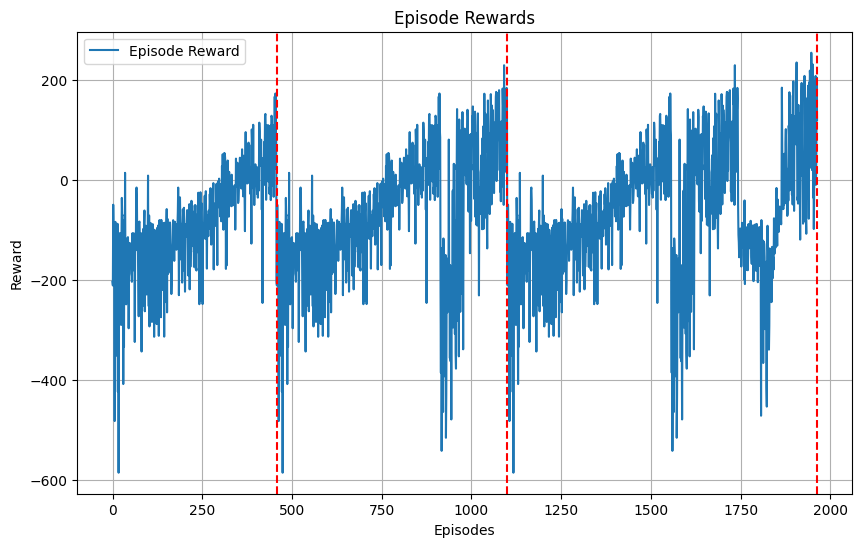

In [103]:
class ActionPermuteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_size = 4
        self.permutation = np.arange(self.action_size)
        self.update_permutation()

    def update_permutation(self):
        np.random.shuffle(self.permutation)
        print("new action permutation:", self.permutation)

    def step(self, action):
        permuted_action = self.permutation[action]
        return self.env.step(permuted_action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


log_file = "lunarlander"
env = gym.make("LunarLander-v3")
env = Monitor(env, filename=log_file)
env = ActionPermuteWrapper(env) 
model = PPO(
    # hyperparam from https://huggingface.co/sb3/ppo-LunarLander-v2
    "MlpPolicy",
    env=env,
    ent_coef=0.01,
    gae_lambda=0.98,
    gamma=0.999,
    verbose=False,
)
episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(3)):
    model.learn(total_timesteps=100000)
    data = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(data["r"])
    epoch_end_idx.append(len(episode_rewards))

    env.update_permutation()

plot_reward(episode_rewards, epoch_end_idx)

## Environment change

  0%|          | 0/3 [00:00<?, ?it/s]

setting:  {'gravity': -10.0, 'wind_power': 5.0}


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 33%|███▎      | 1/3 [00:38<01:16, 38.41s/it]

setting:  {'gravity': -4.745985825796484, 'wind_power': 16.8764080538957}


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 67%|██████▋   | 2/3 [01:37<00:50, 50.47s/it]

setting:  {'gravity': -10.049779575382027, 'wind_power': 1.6152924774241417}


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
100%|██████████| 3/3 [02:20<00:00, 46.69s/it]


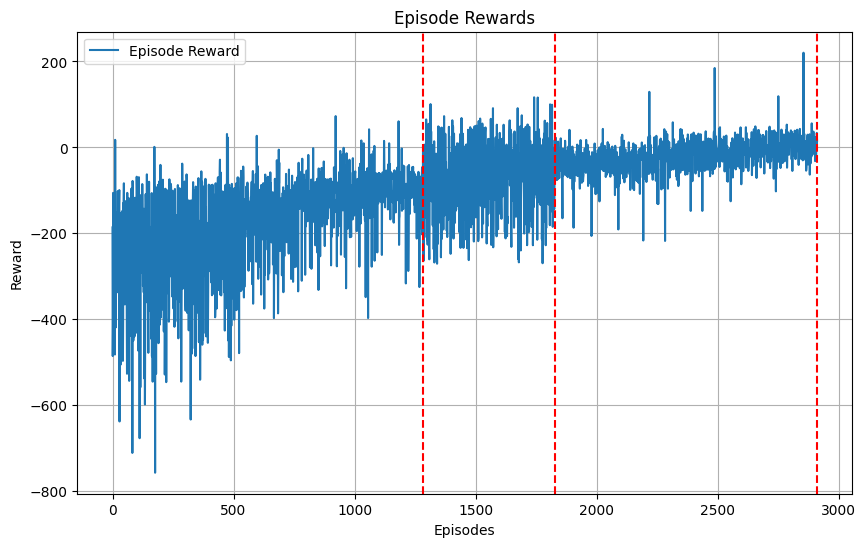

In [107]:
def create_env(log_file, gravity=-10.0, wind_power=5.0):
    env = make_vec_env(
        "LunarLander-v3",
        n_envs=8,
        env_kwargs={"gravity": gravity, "enable_wind": True, "wind_power": wind_power},
    )
    env = VecMonitor(env, filename=log_file)
    return env


def next_setting(cur_setting):
    def next_field(key, low, high, delta):
        cur = cur_setting[key]
        while True:
            x = random.uniform(low, high)
            if abs(cur - x) >= delta: # we want drastic change
                cur_setting[key] = x
                return

    next_field("gravity", -12, -1, delta=4)
    next_field("wind_power", 0, 20, delta=5)


log_file = "lunarlander"
env_setting = {
    "gravity": -10.0,
    "wind_power": 5.0
}
cur_gravity = -10.0
env = create_env(log_file, **env_setting)
model = PPO(
    # hyperparam from https://huggingface.co/sb3/ppo-LunarLander-v2
    "MlpPolicy",
    env=env,
    ent_coef=0.01,
    gae_lambda=0.98,
    gamma=0.999,
    verbose=False,
)
episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(3)):
    print("setting: ", env_setting)

    # check the internal state to verify the gravity change was in effect
    # print("gravity:", env.envs[0].unwrapped.world.gravity)

    model.learn(total_timesteps=100000)
    data = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(data["r"])
    epoch_end_idx.append(len(episode_rewards))

    env.close()
    next_setting(env_setting)
    env = create_env(log_file, **env_setting)
    model.set_env(env)

plot_reward(episode_rewards, epoch_end_idx)

In [108]:
# render the agent demo
def render():
    vec_env = make_vec_env("LunarLander-v3", n_envs=1)
    obs = vec_env.reset()

    for i in range(1000):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        vec_env.render("human")